In [108]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym
!pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import DQN ,A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [110]:
import numpy as np 
from tqdm.notebook import tqdm
from binance.client import Client
import pandas as pd 
from datetime import datetime
import random
import time

def compute_sma(data, window):
    sma = data.rolling(window=window).mean()
    return sma


#select cryptocurrencies you'd like to gather and time interval
coins= ['BTC','ETH','LTC','XLM','XRP','XMR','TRX','LINK','IOTA','EOS','DASH','ZRX']

ratios = [coins[0]]
START_TIME = '16 Aug, 2022'
END_TIME = '17 Aug, 2022'

client = Client()

for ratio in ratios:
    print(f'Gathering {ratio} data...')
    data = client.get_historical_klines(symbol=f'{ratio}USDT',interval=Client.KLINE_INTERVAL_1MINUTE,start_str=START_TIME,end_str=END_TIME)
    cols = ['Date','Open','High','Low',f'{ratio}-USD_close',f'{ratio}-USD_volume','CloseDate','QuoteAssetVolume','NumberOfTrades','TBBAV','TBQAV','null']
    df = pd.DataFrame(data,columns=cols)
    print('complete')
    time.sleep(60) #sleep for a bit so the binance api doesn't kick you out for too many data asks

for col in df.columns:
    if 'Date' not in col:
        df[col] = df[col].astype(np.float64)
    
#clip NaNs
df = df.reset_index(drop=True)

#convert binance timestamp to datetime
for i in tqdm(range(len(df))):
    df['Date'][i] = datetime.fromtimestamp(int(df['Date'][i]/1000))
    df['CloseDate'][i] = datetime.fromtimestamp(int(df['CloseDate'][i]/1000))

df.to_csv('oneDayBTC-16-Aug-2022')

Gathering BTC data...
complete


  0%|          | 0/1441 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
df = pd.read_csv('/content/oneDayBTC-16-Aug-2022')

In [112]:
df.dtypes

Unnamed: 0            int64
Date                 object
Open                float64
High                float64
Low                 float64
BTC-USD_close       float64
BTC-USD_volume      float64
CloseDate            object
QuoteAssetVolume    float64
NumberOfTrades      float64
TBBAV               float64
TBQAV               float64
null                float64
dtype: object

In [113]:
df['Date'] = pd.to_datetime(df['Date']) #عشين المكتبة تعت المداولة تقرا تاريخ و ليس اوبجكت
df['CloseDate'] = pd.to_datetime(df['CloseDate'])
df.dtypes

Unnamed: 0                   int64
Date                datetime64[ns]
Open                       float64
High                       float64
Low                        float64
BTC-USD_close              float64
BTC-USD_volume             float64
CloseDate           datetime64[ns]
QuoteAssetVolume           float64
NumberOfTrades             float64
TBBAV                      float64
TBQAV                      float64
null                       float64
dtype: object

In [114]:
df.set_index('Date', inplace=True) # برضه للمكتبة لتتغل لازم التاريخ يكون هو الفهرس
df.head()

,Unnamed: 0,Open,High,Low,BTC-USD_close,BTC-USD_volume,CloseDate,QuoteAssetVolume,NumberOfTrades,TBBAV,TBQAV,null
Date,,,,,,,,,,,,
2022-08-16 00:00:00,0,24093.04,24108.44,24084.87,24089.78,157.32967,2022-08-16 00:00:59,3.790822e+06,5151.0,86.32121,2.079952e+06,0.0
2022-08-16 00:01:00,1,24087.50,24097.57,24068.09,24097.05,153.59819,2022-08-16 00:01:59,3.698762e+06,5055.0,90.38707,2.176660e+06,0.0
2022-08-16 00:02:00,2,24097.05,24120.00,24075.86,24078.81,160.71048,2022-08-16 00:02:59,3.873279e+06,5116.0,72.05137,1.736507e+06,0.0
2022-08-16 00:03:00,3,24078.81,24090.98,24054.44,24057.18,308.70451,2022-08-16 00:03:59,7.430333e+06,5646.0,198.58601,4.779822e+06,0.0
2022-08-16 00:04:00,4,24055.08,24095.27,24051.57,24088.40,112.13587,2022-08-16 00:04:59,2.699045e+06,4728.0,62.95819,1.515370e+06,0.0


In [115]:
dfForGYM = df.rename(columns = {"BTC-USD_close": "Close", "BTC-USD_volume": "Volume"})[['Open',	'High',	'Low'	,'Close',	'Volume']]

In [116]:
dfForGYM.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-16 00:00:00,24093.04,24108.44,24084.87,24089.78,157.32967
2022-08-16 00:01:00,24087.50,24097.57,24068.09,24097.05,153.59819
2022-08-16 00:02:00,24097.05,24120.00,24075.86,24078.81,160.71048
2022-08-16 00:03:00,24078.81,24090.98,24054.44,24057.18,308.70451
2022-08-16 00:04:00,24055.08,24095.27,24051.57,24088.40,112.13587


In [117]:
env = gym.make('forex-v0', df=dfForGYM, frame_bound=(10,100), window_size=10)
#علمنا انفايرومنت جيددة من نوع فوركس و اعطيناها مساحة 10 مع 100 نقطة من الداتا

In [118]:
env.prices

array([24089.78, 24097.05, 24078.81, 24057.18, 24088.4 , 24071.08,
       24079.91, 24109.98, 24135.83, 24141.51, 24151.65, 24147.26,
       24127.31, 24104.89, 24110.54, 24039.03, 24038.05, 23970.5 ,
       24023.08, 24027.03, 24051.07, 24036.22, 24001.08, 23998.21,
       24010.  , 23994.37, 24004.  , 23984.16, 23997.66, 23994.84,
       23980.45, 24002.82, 23999.61, 24058.51, 24033.45, 24054.55,
       24040.34, 24019.89, 24024.18, 24028.9 , 24045.07, 24060.95,
       24086.85, 24088.43, 24088.51, 24074.09, 24101.25, 24111.72,
       24106.27, 24110.84, 24120.62, 24138.16, 24137.48, 24147.52,
       24149.99, 24127.25, 24118.93, 24117.19, 24126.88, 24124.8 ,
       24136.4 , 24140.55, 24148.96, 24180.88, 24163.89, 24186.82,
       24193.12, 24187.66, 24173.48, 24168.92, 24180.4 , 24186.19,
       24187.9 , 24177.76, 24189.01, 24184.92, 24188.66, 24195.5 ,
       24195.71, 24196.74, 24193.79, 24213.25, 24215.92, 24208.75,
       24212.79, 24207.6 , 24217.41, 24209.05, 24194.53, 24185

In [119]:
env.signal_features
# السعر و قيمة التغيير بالسعر 
# أول قيمة صفر لانها ما في قبلها
# تقريبا فيه فتشر واحدة فقط و لازم ينضاف معادلات محاسبة و رياضة واضافة العديد من الفيشرات

array([[ 2.408978e+04,  0.000000e+00],
       [ 2.409705e+04,  7.270000e+00],
       [ 2.407881e+04, -1.824000e+01],
       [ 2.405718e+04, -2.163000e+01],
       [ 2.408840e+04,  3.122000e+01],
       [ 2.407108e+04, -1.732000e+01],
       [ 2.407991e+04,  8.830000e+00],
       [ 2.410998e+04,  3.007000e+01],
       [ 2.413583e+04,  2.585000e+01],
       [ 2.414151e+04,  5.680000e+00],
       [ 2.415165e+04,  1.014000e+01],
       [ 2.414726e+04, -4.390000e+00],
       [ 2.412731e+04, -1.995000e+01],
       [ 2.410489e+04, -2.242000e+01],
       [ 2.411054e+04,  5.650000e+00],
       [ 2.403903e+04, -7.151000e+01],
       [ 2.403805e+04, -9.800000e-01],
       [ 2.397050e+04, -6.755000e+01],
       [ 2.402308e+04,  5.258000e+01],
       [ 2.402703e+04,  3.950000e+00],
       [ 2.405107e+04,  2.404000e+01],
       [ 2.403622e+04, -1.485000e+01],
       [ 2.400108e+04, -3.514000e+01],
       [ 2.399821e+04, -2.870000e+00],
       [ 2.401000e+04,  1.179000e+01],
       [ 2.399437e+04, -1

In [120]:
env.action_space # فقط اكشنين بيع او اشتري و وفيش هولد 
# hold هي عملية بيع مشروط مؤقتة

Discrete(2)

info {'total_reward': -1590600.0000000496, 'total_profit': 0.994883894847691, 'position': 1}


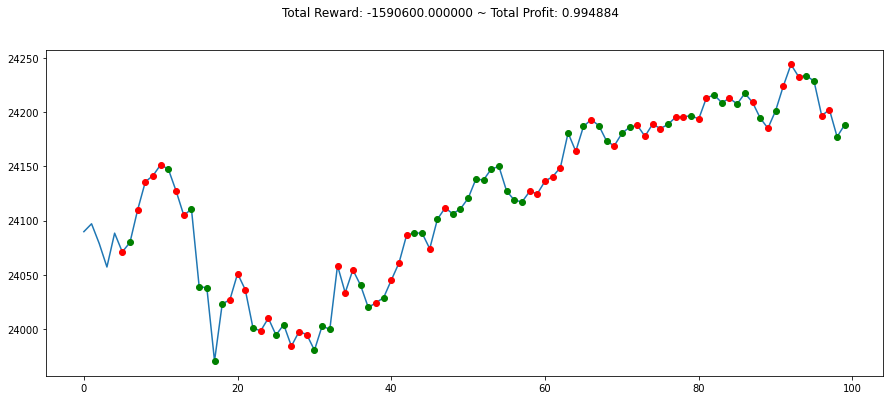

In [140]:
state = env.reset()
while True: 
    action = env.action_space.sample() # علمتا كم خطوة عشوائية بهدف نتأكد انه الانفايرومنت شغالة
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all() # مكتبة جاهزو من المكتبة
plt.show()

In [141]:
env_maker = lambda: gym.make('forex-v0', df=dfForGYM, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])  # Vectorized environments are required when using wrappers for frame-stacking or normalization.

In [144]:
# model = DQN(policy='LnMlpPolicy', env=env, verbose=1)
# policy: (DQNPolicy or str) ['CnnPolicy', 'LnCnnPolicy', 'MlpPolicy', 'LnMlpPolicy']
model = A2C(policy='MlpPolicy', env=env, verbose=1)
# ['CnnPolicy', 'CnnLstmPolicy', 'CnnLnLstmPolicy', 'MlpPolicy', 'MlpLstmPolicy', 'MlpLnLstmPolicy']
model.learn(total_timesteps=1000000)

--------------------------------------
| % time spent exploring  | 90       |
| episodes                | 100      |
| mean 100 episode reward | 5.38e+04 |
| steps                   | 9306     |
--------------------------------------


KeyboardInterrupt: ignored

In [156]:
env = gym.make('forex-v0', df=dfForGYM, frame_bound=(950,1000), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 1007999.9999998836, 'total_profit': 1.0042590559893123, 'position': 1}


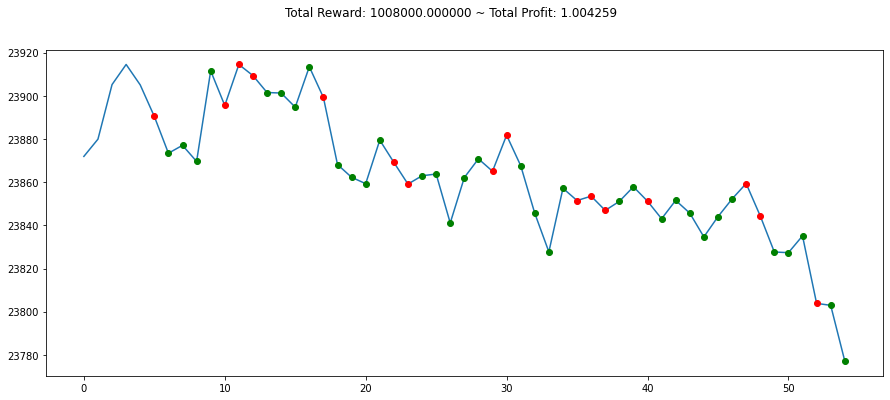

In [157]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()